#### Definitions

In [1]:
import time
import json
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from py2neo import Graph, Node, Relationship
%matplotlib inline



In [2]:
def query_to_df(query, graph):
    print("Starting query...", end=" ")
    query_start_time = time.time()
    df = graph.run(query).to_data_frame()
    print("Done ({:.2f} minutes).".format((time.time()-query_start_time)/60))
    return df

In [3]:
graph = Graph( "bolt://matlaber10.media.mit.edu:7687", auth=('neo4j','myneo'))
print("Connected to graph database with {:,} nodes and {:,} relationships!".format(
    graph.database.primitive_counts['NumberOfNodeIdsInUse'], 
    graph.database.primitive_counts['NumberOfRelationshipIdsInUse']))

Connected to graph database with 278,432,359 nodes and 1,844,501,832 relationships!


#### High-level Inventory

In [4]:
d = graph.run("MATCH (a:NatureAuthor) RETURN COUNT(a) as number_of_nature_authors").data()[0]
num_nature_authors = d['number_of_nature_authors']
print("Number of authors: {:,}".format(num_nature_authors))

Number of authors: 293,023


In [21]:
print("Author properties:")
d = graph.run("MATCH (a:NatureAuthor) RETURN properties(a), ID(a)").data()
print(d[0])
print(d[1])

Author properties:
{'properties(a)': {'name': 'Zev Rosenwaks', 'labelprop': 1232, 'louvain': [1, 1, 1, 1]}, 'ID(a)': 9}
{'properties(a)': {'labelprop': 1232, 'name': 'David R. McClay', 'louvain': [7, 6, 5, 5]}, 'ID(a)': 42}


In [26]:
print("Node types")
d = graph.run("CALL db.labels() YIELD label RETURN label;").data()
d

Node types


[{'label': 'Quanta'},
 {'label': 'Author'},
 {'label': 'Organization'},
 {'label': 'Patent'},
 {'label': 'PhysicsAuthor'},
 {'label': 'NatureAuthor'},
 {'label': 'Top42Author'}]

In [25]:
print("Relationship types")
d = graph.run("CALL db.relationshipTypes() YIELD relationshipType RETURN relationshipType;").data()
d


Relationship types


[{'relationshipType': 'AUTHORED'},
 {'relationshipType': 'AFFILIATED_WITH'},
 {'relationshipType': 'CITES'},
 {'relationshipType': 'COAUTHOR'}]

In [29]:
d = graph.run("CALL db.propertyKeys() YIELD propertyKey  RETURN propertyKey").data()
d

[{'propertyKey': 'id'},
 {'propertyKey': 'name'},
 {'propertyKey': 'year'},
 {'propertyKey': 'lang'},
 {'propertyKey': 'fos'},
 {'propertyKey': 'title'},
 {'propertyKey': 'refs'},
 {'propertyKey': 'url'},
 {'propertyKey': 'keywords'},
 {'propertyKey': 'n_citation'},
 {'propertyKey': 'pdf'},
 {'propertyKey': 'publisher'},
 {'propertyKey': 'is_first_author'},
 {'propertyKey': 'is_last_author'},
 {'propertyKey': 'venue'},
 {'propertyKey': 'classifications'},
 {'propertyKey': 'location'},
 {'propertyKey': 'pub_date'},
 {'propertyKey': 'also_published_as'},
 {'propertyKey': 'cited_by'},
 {'propertyKey': 'authors'},
 {'propertyKey': 'patent_citations'},
 {'propertyKey': 'pagerank'},
 {'propertyKey': 'pageRank_2018'},
 {'propertyKey': 'pageRank_2008'},
 {'propertyKey': 'articleRank2018'},
 {'propertyKey': 'pagerank_yr'},
 {'propertyKey': 'pagerank_2018'},
 {'propertyKey': 'articlerank'},
 {'propertyKey': 'doctype'},
 {'propertyKey': 'tspr2008'},
 {'propertyKey': 'tspr2009'},
 {'propertyKey': 

#### Number of coauthors

In [4]:
query = """MATCH (a:NatureAuthor)
WITH a, size((a)-[:COAUTHOR]-()) as Num_Coauthors
RETURN a.name, Num_Coauthors"""

df_coauthors = query_to_df(query, graph)
degree_df = df_coauthors['Num_Coauthors']

print("Coauthorship statistics:\n")
degree_df.describe()

Starting query... Done (0.12 minutes).
Coauthorship statistics:



count    293023.000000
mean        242.165444
std        1076.219890
min           0.000000
25%           7.000000
50%          31.000000
75%         108.000000
max       30581.000000
Name: Num_Coauthors, dtype: float64

In [5]:
print("Rank by number of coauthors:")
df_coauthors.sort_values('Num_Coauthors', ascending=False).head(5)


Rank by number of coauthors:


,Num_Coauthors,a.name
491,30581,J. Zhang
2440,27253,H. Kim
8488,26742,L. Zhang
6271,25869,H. Wang
645,24633,J. Wang


#### Number of coauthors in different communities

In [5]:
query = """MATCH (a:NatureAuthor)-[:COAUTHOR]-(b)
WHERE NOT b.louvain[3] = a.louvain[3]
WITH a, size(collect(b)) AS Num_Coauthors_In_Different_Community
RETURN a.name, Num_Coauthors_In_Different_Community"""

df_diff_community = query_to_df(query, graph)
degree_df = df_diff_community['Num_Coauthors_In_Different_Community']

print("Coauthorship statistics:\n")
df_diff_community.describe()

Starting query... Done (3.01 minutes).
Coauthorship statistics:



,Num_Coauthors_In_Different_Community
count,242468.000000
mean,67.208263
std,243.571189
min,1.000000
25%,4.000000
50%,12.000000
75%,39.000000
max,10648.000000


In [40]:
print("Rank by number of coauthors in different communities:")
df_diff_community.sort_values('Num_Coauthors_In_Different_Community', ascending=False).head(5)


Rank by number of coauthors in different communities:


,Num_Coauthors_In_Different_Community,a.name
197893,10648,Wei Li
200893,8335,Yang Liu
45903,8249,H. Wang
133356,8118,L. Zhang
192443,8061,Wei Wang


#### Proportion of coauthors in different communities

In [6]:
df_coauthors.head(5)

,Num_Coauthors,a.name
0,430,Zev Rosenwaks
1,290,David R. McClay
2,60,Efrain C. Azmitia
3,360,Robert P. Schleimer
4,433,Rosanna W. Peeling


In [7]:
df_diff_community.head(5)

,Num_Coauthors_In_Different_Community,a.name
0,20,Bruce E. White
1,26,Nils-Erik Heldin
2,3,Alex Klemm
3,3,Pei-Song Gao
4,3,Edward James Morgan


#### Number of coauthors affiliated with different organizations

In [ ]:
query = """MATCH (a:NatureAuthor)-[:AFFILIATED_WITH]-(b)
WITH a, collect(b) as organizations
RETURN a.name, organizations"""

df = query_to_df(query, graph)

Starting query... 

In [36]:
df['organizations'][0]

[(_243856022:Organization {name: '#N#a#N#Freescale Semiconductor Incorporated, Advanced Products Research and Development Laboratory, Austin, Texas 78721, USA #N#'}),
 (_16187995:Organization {name: 'Digital DNA Labs., Motorola Inc., Austin, TX, USA'}),
 (_235152802:Organization {name: 'DigitalDNA Laboratories, Semiconductor Products Sector, Motorola, Austin, Texas 78721'}),
 (_227931243:Organization {name: 'Technology Solutions Organization, Motorola SPS, Austin, TX 78721, USA'}),
 (_197919844:Organization {name: 'Digital DNA Laboratories, Motorola, Austin, TX 78721, U.S.A'}),
 (_197070806:Organization {name: 'Motorola, Materials Research and Strategic Technologies , 3501 Ed Bluestein Blvd., MD-K10, Austin, Texas, 78721, U.S.A. '}),
 (_178741015:Organization {name: 'Motorola, Inc., Advanced Products Research and Development Laboratory Austin, TX 78721'}),
 (_176376679:Organization {name: 'Digital DNA Lab., APRDL, Austin, TX, USA'}),
 (_175188731:Organization {name: 'Motorola Digital D

#### Cross-cluster and intra-cluster edges

In [4]:
query = """call apoc.export.csv.query("

// denominator

MATCH (u:NatureAuthor)

MATCH (u)-[e:COAUTHOR]-(b:NatureAuthor)

WITH e.strength AS weight, u, COUNT(b) AS k_u

WITH u, toFloat(sum(weight*k_u))/sum(k_u) AS den



// intracommunity focus

OPTIONAL MATCH (u)-[e:COAUTHOR]-(b:NatureAuthor)

WHERE last(b.louvain) = last(u.louvain)

WITH den, u, COUNT(b) AS k_intra_u, CASE WHEN e IS NULL THEN 0 ELSE e.strength END AS weight

WITH den, u, CASE WHEN sum(k_intra_u)=0 THEN 0 ELSE toFloat(sum(weight*k_intra_u))/sum(k_intra_u) END AS num

WITH den, u, CASE WHEN den=0 THEN 0 ELSE num/den END AS NatureIntraCommunityFocus

WITH den, u, NatureIntraCommunityFocus



// intercommunity focus

OPTIONAL MATCH (u)-[e:COAUTHOR]-(b:NatureAuthor)

WHERE last(b.louvain) <> last(u.louvain)

WITH den, u, NatureIntraCommunityFocus, COUNT(b) AS k_inter_u, CASE WHEN e IS NULL THEN 0 ELSE e.strength END AS weight

WITH den, u, NatureIntraCommunityFocus, CASE WHEN sum(k_inter_u)=0 THEN 0 ELSE toFloat(sum(weight*k_inter_u))/sum(k_inter_u) END AS num

WITH u, NatureIntraCommunityFocus, CASE WHEN den=0 THEN 0 ELSE num/den END AS NatureInterCommunityFocus



RETURN u.name, NatureIntraCommunityFocus, NatureInterCommunityFocus

","/import/result/author_focus.csv",{})"""

df_community_focus = query_to_df(query, graph)

Starting query... Done (11.96 minutes).


#### Professor + Professor: Two last authors

In [20]:
#Check pct_last_author calc works
query = """
MATCH (a:Top42Author)-[r:AUTHORED]-(q:QUANTA)
RETURN a.name, SUM(CASE WHEN r.is_last_author THEN 1 ELSE 0 END)/COUNT(r) as pct_last_author
LIMIT 5
"""

df_prof_small = query_to_df(query, graph)

Starting query... Done (0.00 minutes).


In [7]:
#Find number of prof-prof connections
query = """
MATCH (b)-[:COAUTHOR]-(a:Top42Author)-[r:AUTHORED]-(q:Quanta)
WHERE q.year > 2017
WITH a, collect(b) as candidates, SUM(CASE WHEN r.is_last_author THEN 1 ELSE 0 END)/COUNT(r) as pct_last_author

RETURN a, size(collect(b)) AS prof_connections
"""

df_small_conn = query_to_df(query, graph)

Starting query... Done (0.59 minutes).


In [ ]:
#Augment nodes with pct_last_author
query = """call apoc.periodic.iterate(
"MATCH (a:Top42Author)-[r:AUTHORED]-(q:Quanta)
RETURN a, r",
"MATCH (a)
WITH a, SUM(CASE WHEN r.is_last_author THEN 1 ELSE 0 END)/COUNT(r) as pct_last_author
SET a.pct_last_author = pct_last_author", {batchSize:100, parallel:true})
"""

df_last_author = query_to_df(query, graph)

Starting query... 

In [22]:
#Rank by num prof-prof connections
query = """
MATCH (b)-[:COAUTHOR]-(a:Top42Author)-[r:AUTHORED]-(q:Quanta)
WHERE a.pct_last_author > .5 AND b.pct_last_author > .5
RETURN a.name AS name, COUNT(q) as coauthor_profs
"""

df_prof_conns = query_to_df(query, graph)

Starting query... Done (0.05 minutes).


In [24]:
df_prof_conns.describe()

,coauthor_profs
count,164.000000
mean,121.304878
std,509.806765
min,1.000000
25%,2.000000
50%,12.000000
75%,83.250000
max,6016.000000


In [27]:
df_prof_conns.sort_values('coauthor_profs', ascending = False).head(5)

,coauthor_profs,name
86,6016,X. Wang
23,2142,Salvatore DiMauro
158,871,Colin Norman
115,762,Liu Hu
108,630,J. R. Partington


In [5]:
#Write as csv
query = """call apoc.export.csv.query("
MATCH (b)-[:COAUTHOR]-(a:NatureAuthor)-[r:AUTHORED]-(q:Quanta)
WHERE a.pct_last_author > .5 AND b.pct_last_author > .5
RETURN a.name AS name, COUNT(q) as coauthor_profs
","/import/result/prof_count.csv",{})"""

df_prof_count = query_to_df(query, graph)

Starting query... Done (0.02 minutes).


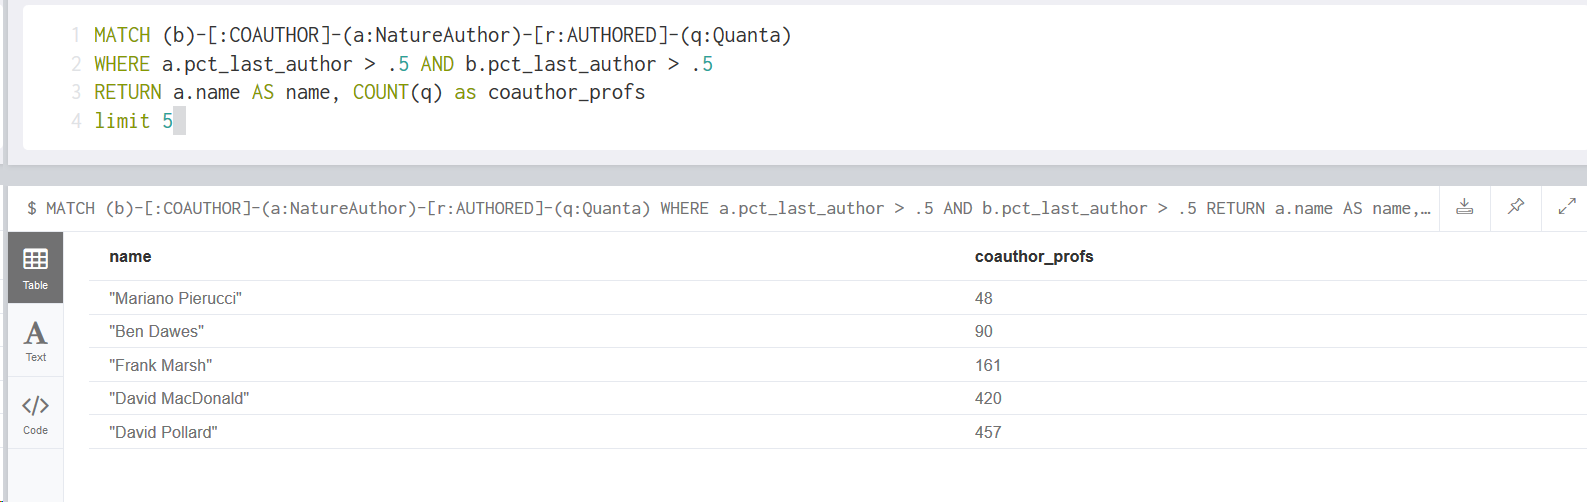

In [4]:
#Ratio of prof-prof connected papers
query = """call apoc.export.csv.query("
MATCH (c)-[:COAUTHOR]-(a:NatureAuthor)-[r2:AUTHORED]-(q2:Quanta)
WHERE a.pct_last_author > .5
WITH a, COUNT(q2) AS denom
MATCH (b)-[:COAUTHOR]-(a)-[r:AUTHORED]-(q:Quanta)
WHERE b.pct_last_author > .5
WITH a, denom, COUNT(q) as num
RETURN a.name AS name, num/denom AS coauthor_profs_ratio
","/import/result/prof_to_prof.csv",{})"""

df_prof_ratio = query_to_df(query, graph)

Starting query... Done (3.14 minutes).


In [8]:
#Ratio of prof-prof connected papers weighted with PR18
query = """call apoc.export.csv.query("
MATCH (c)-[:COAUTHOR]-(a:NatureAuthor)-[r2:AUTHORED]-(q2:Quanta)
WHERE a.pct_last_author > .5
WITH a, SUM(q2.pageRank_2018) AS denom
MATCH (b)-[:COAUTHOR]-(a)-[r:AUTHORED]-(q:Quanta)
WHERE b.pct_last_author > .5
WITH a, denom, SUM(q.pageRank_2018) as num
RETURN a.name AS name, num/denom AS coauthor_profs_weighted
","/import/result/profs_ratio_weighted", {})"""
df_prof_ratio = query_to_df(query, graph)

Starting query... Done (4.83 minutes).


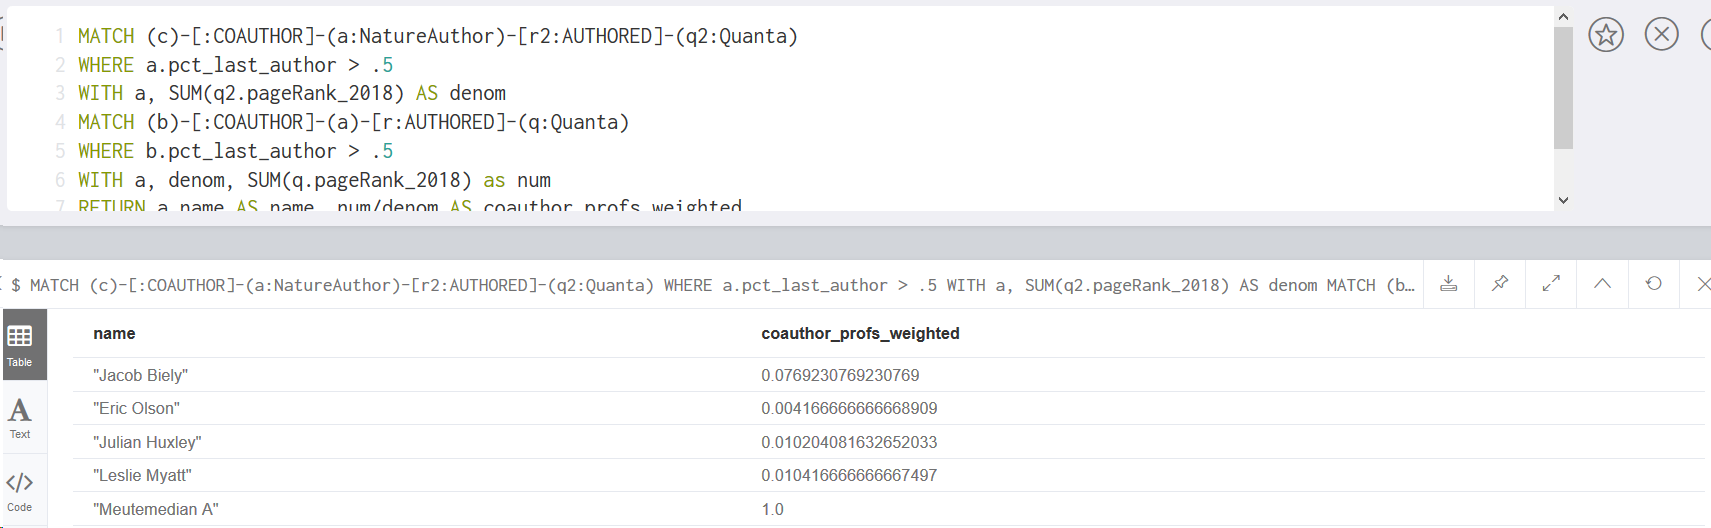


In [9]:
#Ratio of prof-prof connected papers weighted with tspr10
query = """call apoc.export.csv.query("
MATCH (c)-[:COAUTHOR]-(a:NatureAuthor)-[r2:AUTHORED]-(q2:Quanta)
WHERE a.pct_last_author > .5
WITH a, SUM(q2.tspr2010) AS denom
MATCH (b)-[:COAUTHOR]-(a)-[r:AUTHORED]-(q:Quanta)
WHERE b.pct_last_author > .5
WITH a, denom, SUM(q.tspr2010) as num
RETURN a.name AS name, num/denom AS coauthor_profs_tspr10
","/import/result/profs_ratio_tspr10", {})"""
df_prof_ratio = query_to_df(query, graph)

Starting query... Done (4.82 minutes).
